In [1]:
import numpy as np
import cv2

import matplotlib.pyplot as plt

# Read image metadata

In [2]:
from PIL import Image
from PIL.TiffTags import TAGS

with Image.open('data/1941.tiff') as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

In [3]:
meta_dict

{'ImageWidth': (2007,),
 'ImageLength': (2048,),
 'BitsPerSample': (16,),
 'Compression': (1,),
 'PhotometricInterpretation': (1,),
 'ResolutionUnit': (3,),
 'StripOffsets': (8,),
 'Orientation': (4,),
 'SampleFormat': (1,),
 'SamplesPerPixel': (1,),
 'RowsPerStrip': (2048,),
 'StripByteCounts': (8220672,),
 'XResolution': ((4294967295, 8677676),),
 'YResolution': ((4294967295, 8677676),),
 'PlanarConfiguration': (1,)}

# Read data

In [23]:
img1 = cv2.imread('data/0932.tiff', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('data/1941.tiff', cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

In [24]:
img1.shape, img2.shape

((1024, 1005), (1024, 1005))

In [299]:
# Convert all datasets to videos (for better visualization)
from pathlib import Path

def get_tiff_dict(path):
    tiff_files = Path(path).rglob('*.tiff')
    tiff_dirs = {}
    for tiff_file in tiff_files:
        tiff_file = str(tiff_file)
        if tiff_file.split('/')[-1][0] == '.':
            continue
            
        tiff_dir = '/'.join(tiff_file.split('/')[: -1])
        if tiff_dir in tiff_dirs.keys():
            tiff_dirs[tiff_dir].append(tiff_file)
        else:
            tiff_dirs[tiff_dir] = [tiff_file]
    
    return tiff_dirs

def create_tiff_videos(path):
    tiff_dirs = get_tiff_dict(path)
    
    for tiff_dir in tiff_dirs.keys():
        size = ()
        
        img = cv2.imread(tiff_dirs[tiff_dir][0])
        height, width, layers = img.shape
        size = (width, height)
        save_path = 'data/' + tiff_dir.split('/')[-1]

        out = cv2.VideoWriter(save_path + '.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
        
        for tiff_file in sorted(tiff_dirs[tiff_dir]):
            img = cv2.imread(tiff_file)
            out.write(img)
        
        out.release()

create_tiff_videos('/media/chethan749/Honeycomb/combined/')

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
Open

# Initial analysis - Simple image processing operations

In [17]:
def normalize(img):
    return np.array(img / np.max(img) * 255, dtype='uint8')

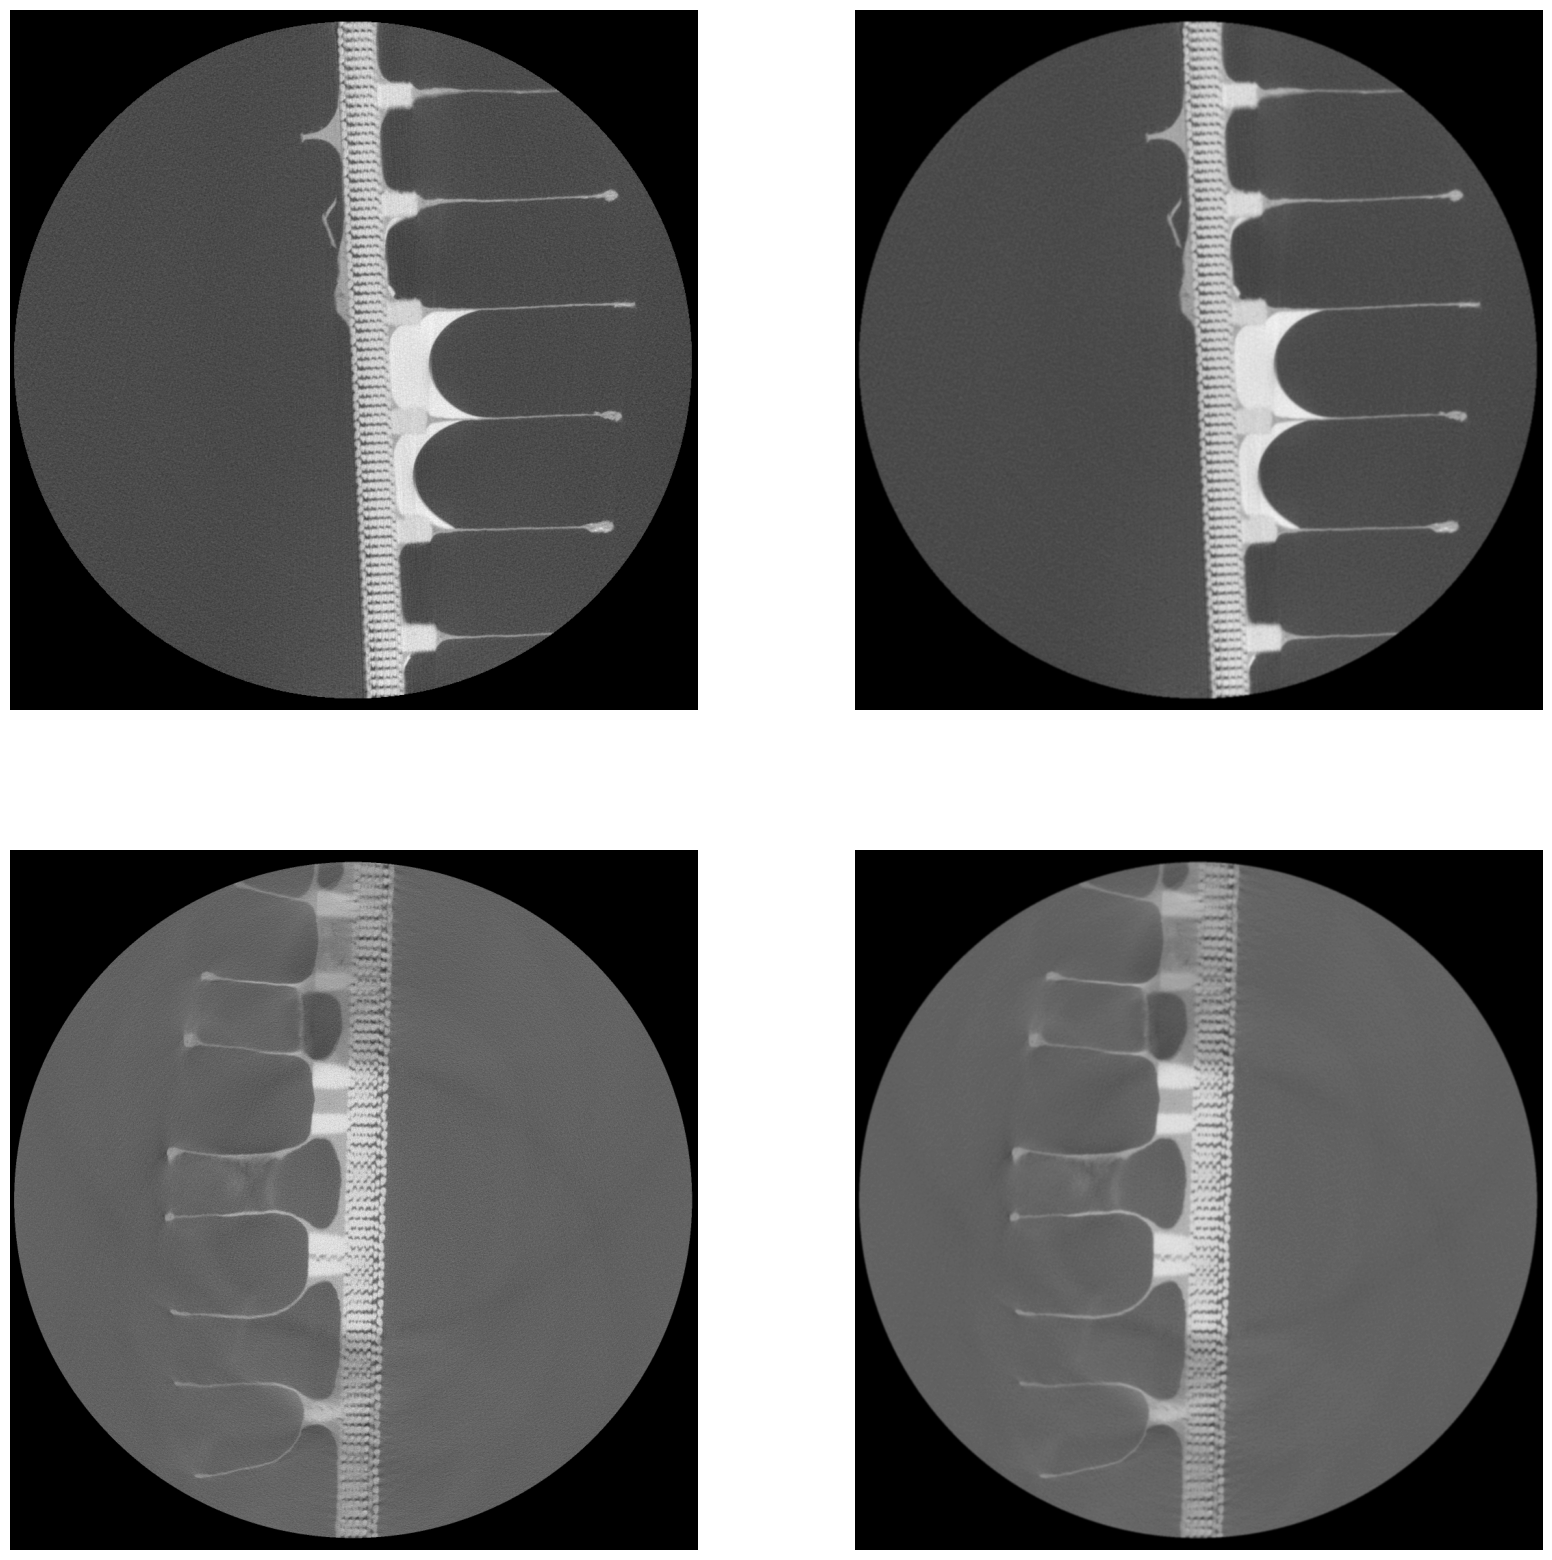

In [25]:
# Gaussian blur to remove noise
img1 = normalize(img1)
img2 = normalize(img2)
blurred_img1 = cv2.GaussianBlur(img1,(5,5),0)
blurred_img2 = cv2.GaussianBlur(img2,(5,5),0)

fig = plt.figure(figsize = (20, 20))
fig1 = fig.add_subplot(221)
fig2 = fig.add_subplot(222)
fig3 = fig.add_subplot(223)
fig4 = fig.add_subplot(224)

fig1.axis('off')
fig2.axis('off')
fig3.axis('off')
fig4.axis('off')
fig1.imshow(img1, cmap='gray', vmin=0, vmax=255)
fig2.imshow(blurred_img1, cmap='gray', vmin=0, vmax=255)
fig3.imshow(img2, cmap='gray', vmin=0, vmax=255)
fig4.imshow(blurred_img2, cmap='gray', vmin=0, vmax=255)

# Threshold and Contour

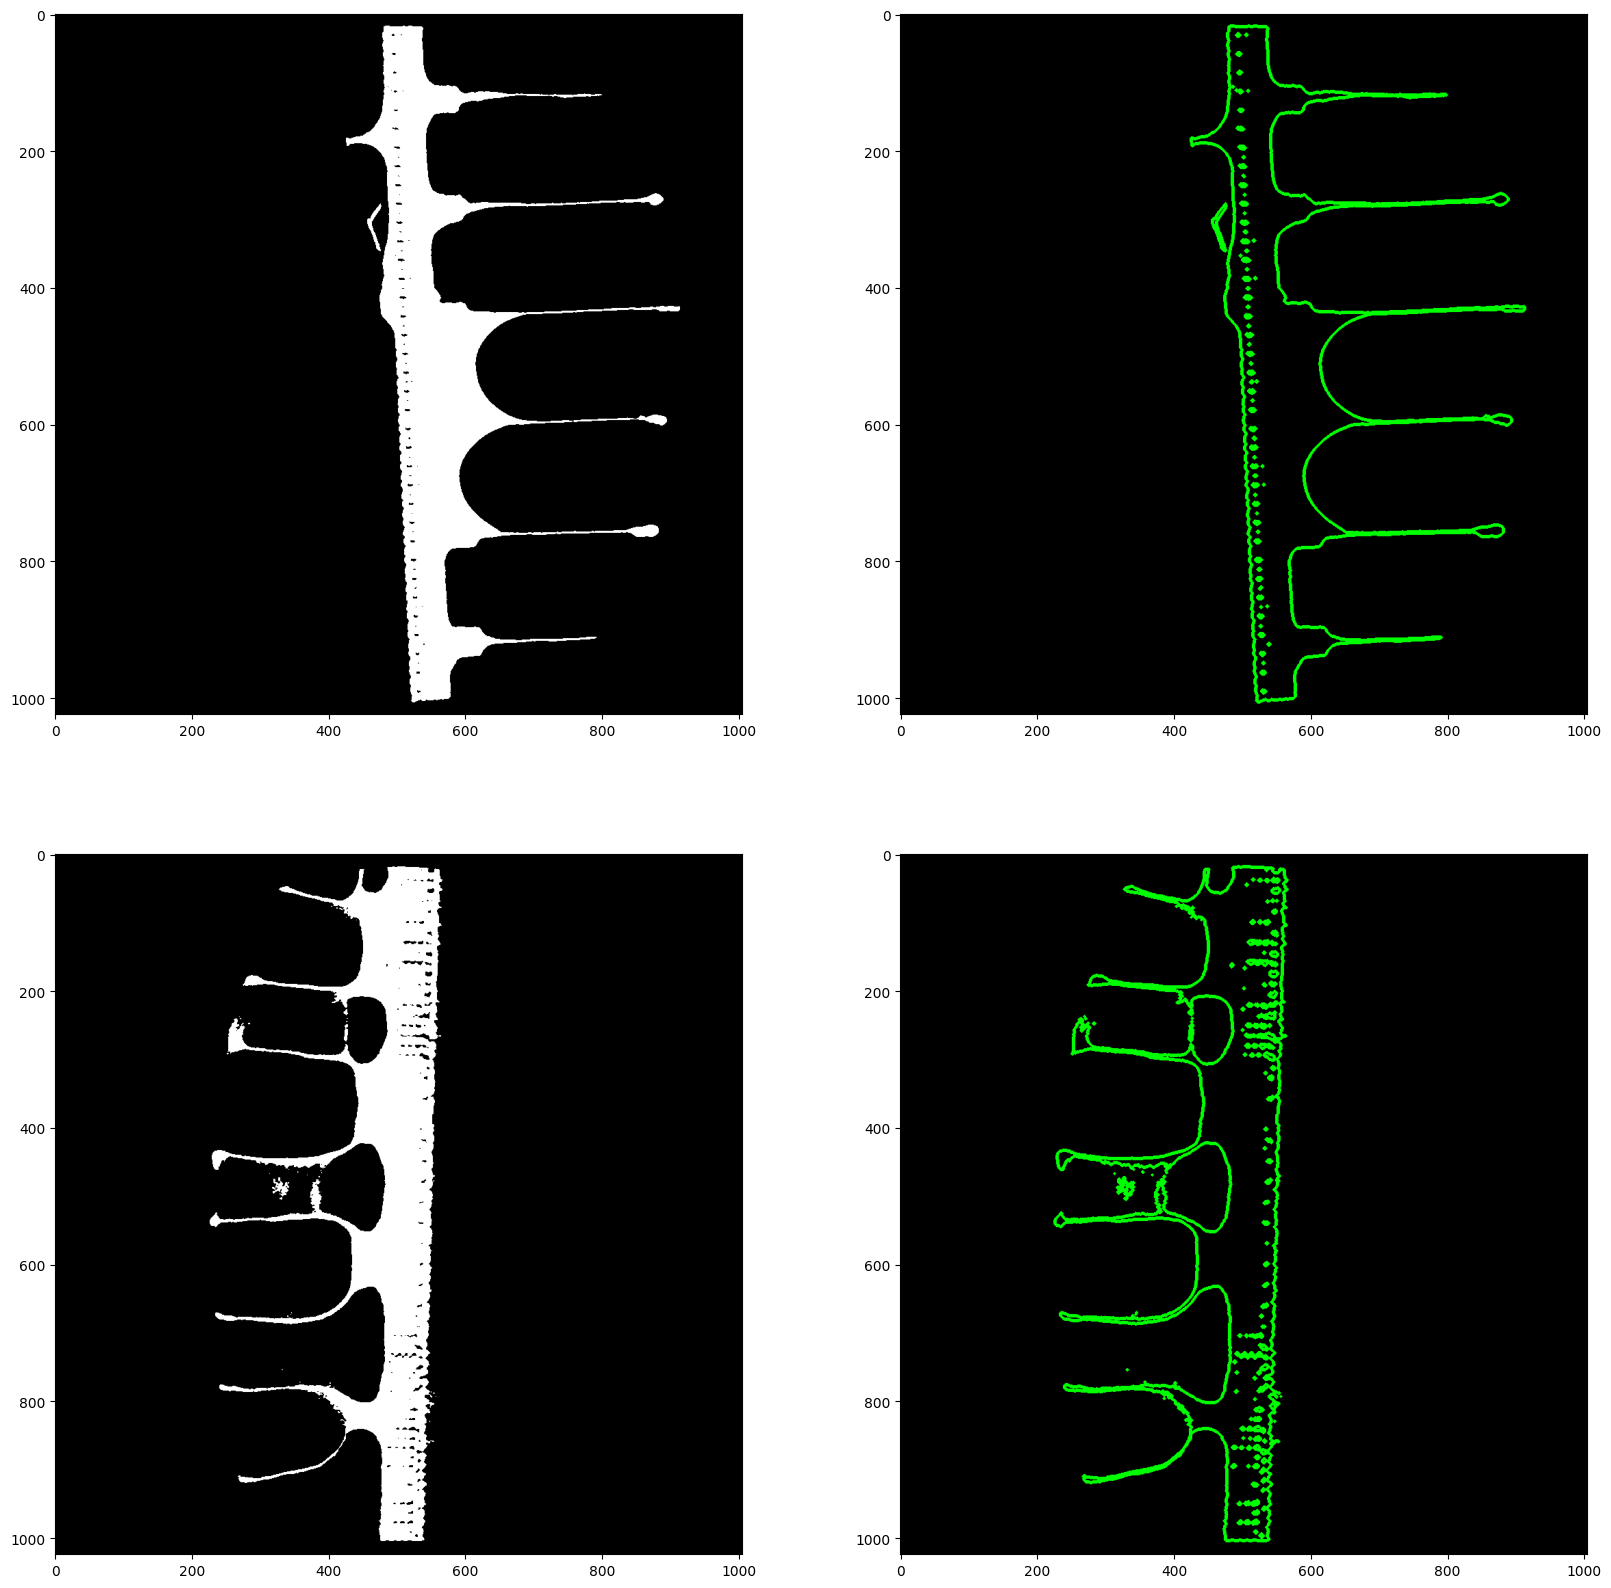

In [26]:
# Threshold and get contours. TODO: Any ways to automate finding threshold value?
def get_thresh_contours(img):
    # Threshold value of 110 is chosen based on trial and error
    ret, thresh = cv2.threshold(img, 110, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
    cv2.drawContours(contour_img, contours, -1, (0,255,0), 3)
    
    return thresh, contour_img

thresh1, contour_img1 = get_thresh_contours(blurred_img1)
thresh2, contour_img2 = get_thresh_contours(blurred_img2)

fig = plt.figure(figsize = (20, 20))
fig1 = fig.add_subplot(221)
fig2 = fig.add_subplot(222)
fig3 = fig.add_subplot(223)
fig4 = fig.add_subplot(224)
fig1.imshow(thresh1, cmap='gray', vmin=0, vmax=255)
fig2.imshow(contour_img1, cmap='gray', vmin=0, vmax=255)
fig3.imshow(thresh2, cmap='gray', vmin=0, vmax=255)
fig4.imshow(contour_img2, cmap='gray', vmin=0, vmax=255)

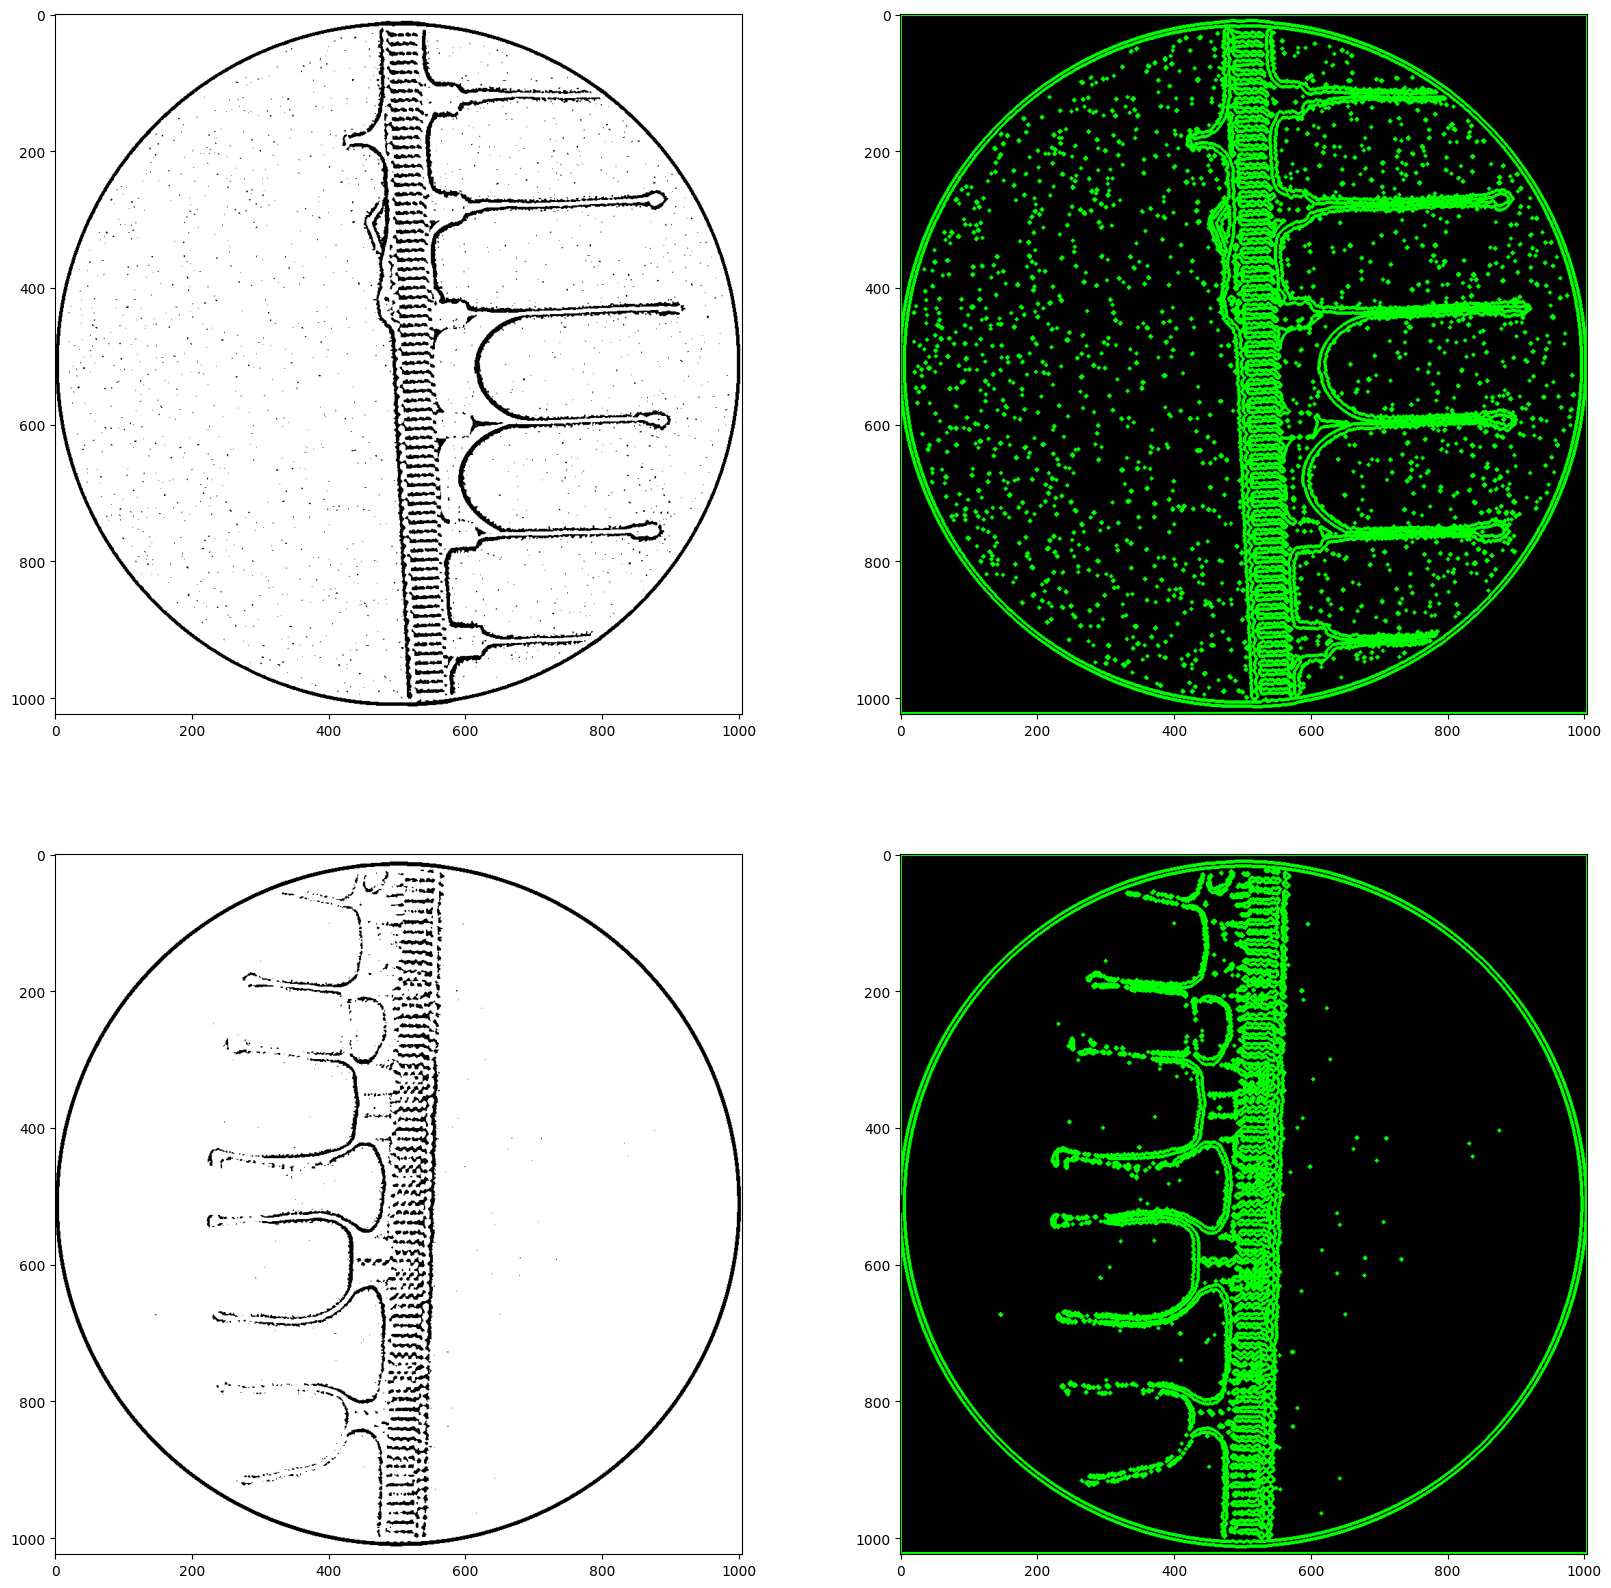

In [37]:
def get_adaptive_thresh_contours(img):
    # Threshold value of 110 is chosen based on trial and error
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 6)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
    cv2.drawContours(contour_img, contours, -1, (0,255,0), 3)
    
    return thresh, contour_img

thresh1, contour_img1 = get_adaptive_thresh_contours(blurred_img1)
thresh2, contour_img2 = get_adaptive_thresh_contours(blurred_img2)

fig = plt.figure(figsize = (20, 20))
fig1 = fig.add_subplot(221)
fig2 = fig.add_subplot(222)
fig3 = fig.add_subplot(223)
fig4 = fig.add_subplot(224)
fig1.imshow(thresh1, cmap='gray', vmin=0, vmax=255)
fig2.imshow(contour_img1, cmap='gray', vmin=0, vmax=255)
fig3.imshow(thresh2, cmap='gray', vmin=0, vmax=255)
fig4.imshow(contour_img2, cmap='gray', vmin=0, vmax=255)

# Edge detection

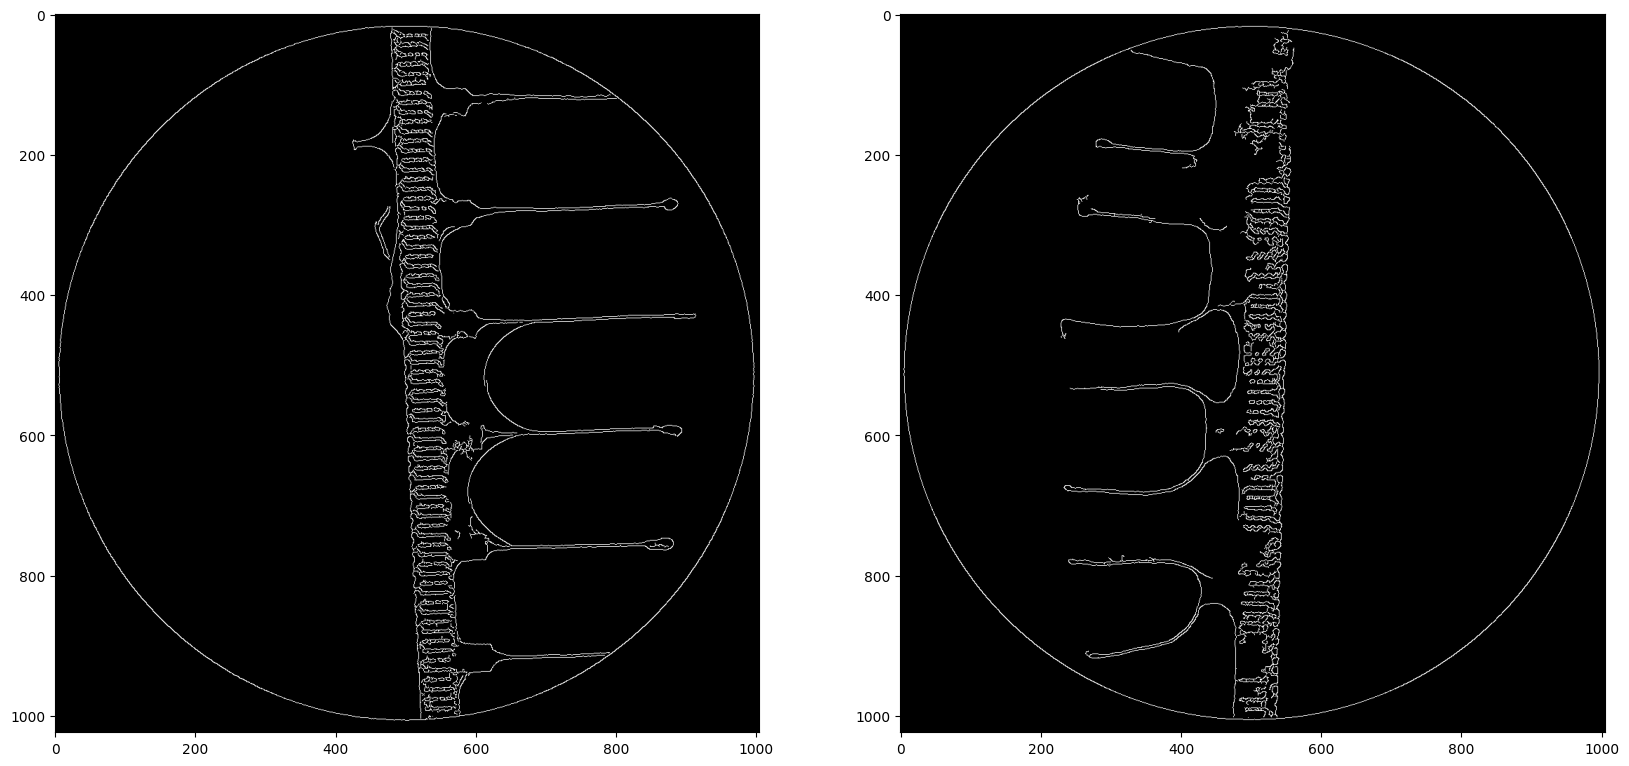

In [38]:
def auto_canny(img, sigma = 0.8):
    v = np.median(img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(img, lower, upper)

edges1 = auto_canny(blurred_img1)
edges2 = auto_canny(blurred_img2)
    
fig = plt.figure(figsize = (20, 20))
fig1 = fig.add_subplot(121)
fig2 = fig.add_subplot(122)
fig1.imshow(edges1, cmap='gray', vmin=0, vmax=255)
fig2.imshow(edges2, cmap='gray', vmin=0, vmax=255)

# Superpixel segmentation

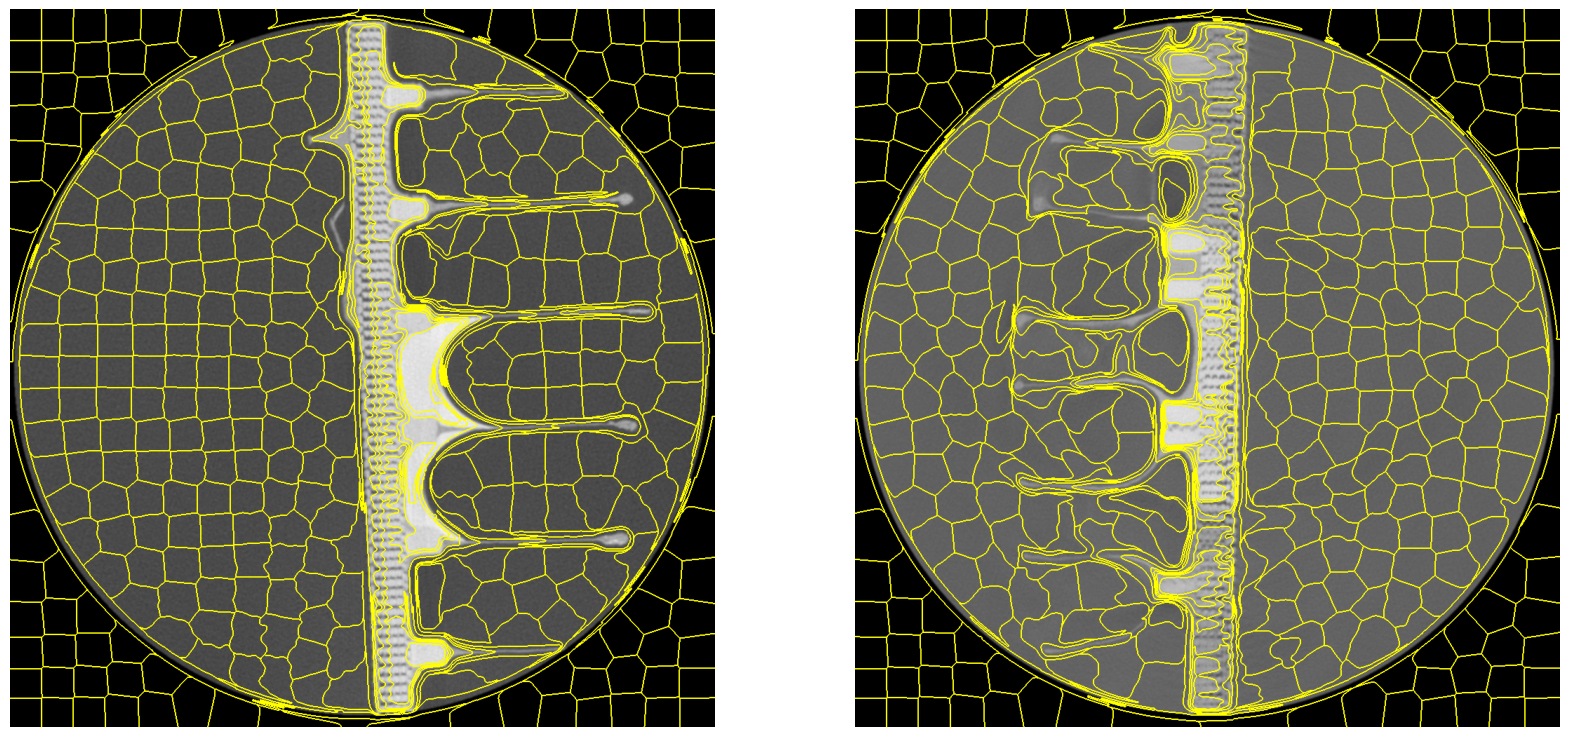

In [39]:
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

fig = plt.figure(figsize = (20, 20))

segments = slic(img_as_float(blurred_img1), compactness = 0.01, n_segments = 500, sigma = 5)
# show the output of SLIC
ax = fig.add_subplot(1, 2, 1)
ax.imshow(mark_boundaries(blurred_img1, segments))
plt.axis("off")

segments = slic(img_as_float(blurred_img2), compactness = 0.01, n_segments = 500, sigma = 5)
# show the output of SLIC
ax = fig.add_subplot(1, 2, 2)
ax.imshow(mark_boundaries(blurred_img2, segments))
plt.axis("off")

# show the plots
plt.show()

# Background subtraction

In [167]:
def get_avg_img(img_files, alpha = 0.005):
    avg_img = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
    for img_path in img_files[1:]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img,(7,7),0)
        avg_img = (1 - alpha) * avg_img + (alpha) * img
        avg_img = cv2.GaussianBlur(avg_img,(7,7),0)
    
    return np.array(avg_img, dtype='uint8')

tiff_dirs = get_tiff_dict('/media/chethan749/Honeycomb/combined/')
avg_img = get_avg_img(tiff_dirs[list(tiff_dirs.keys())[0]])

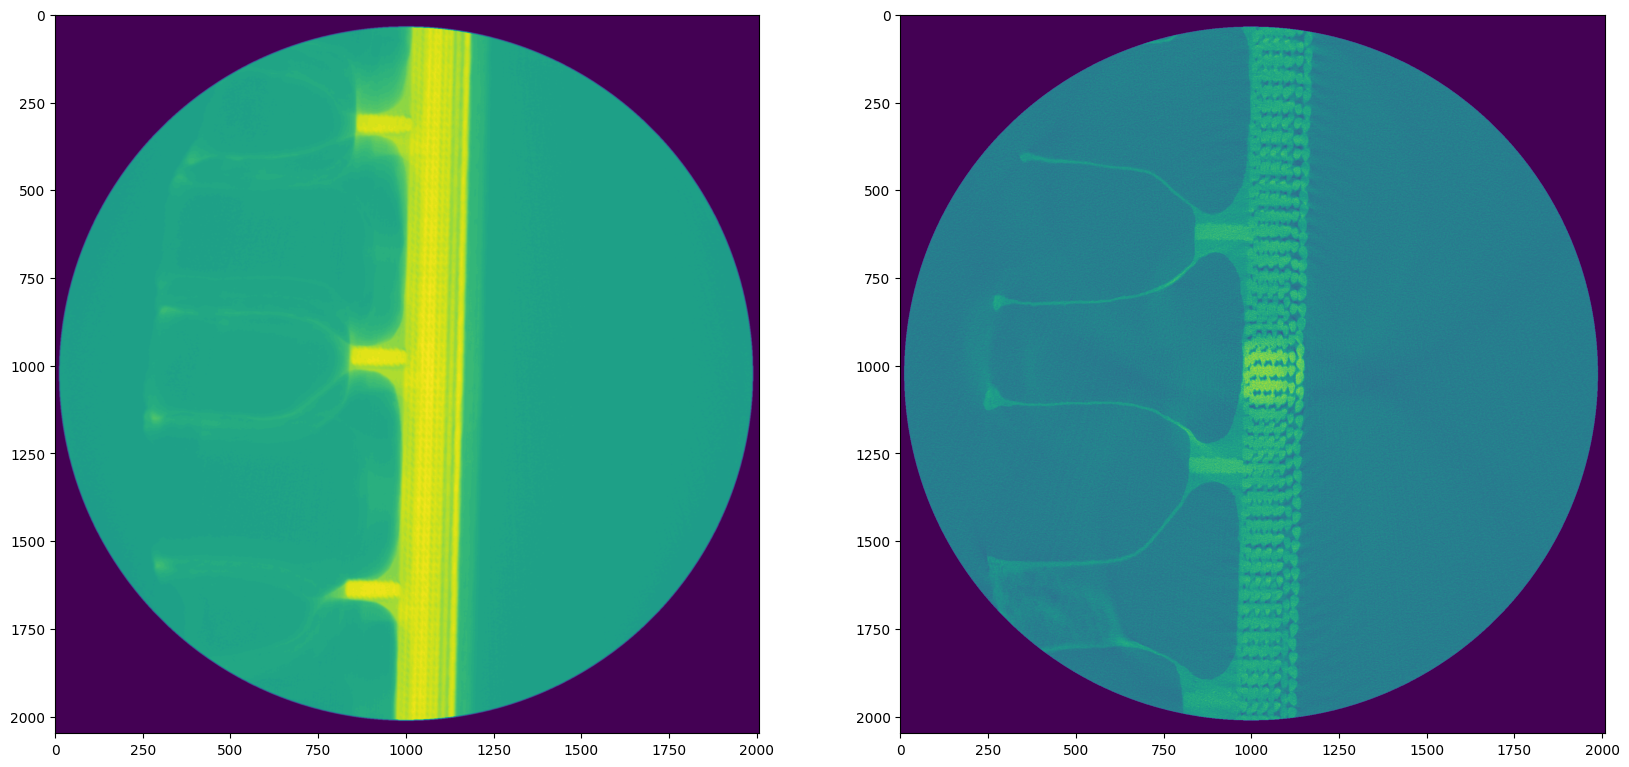

In [297]:
fig = plt.figure(figsize = (20, 10))
fig1 = fig.add_subplot(121)
fig2 = fig.add_subplot(122)

img1 = cv2.imread(tiff_dirs[list(tiff_dirs.keys())[0]][110], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(tiff_dirs[list(tiff_dirs.keys())[0]][600], cv2.IMREAD_GRAYSCALE)
fig1.imshow(avg_img)
fig2.imshow(img1)

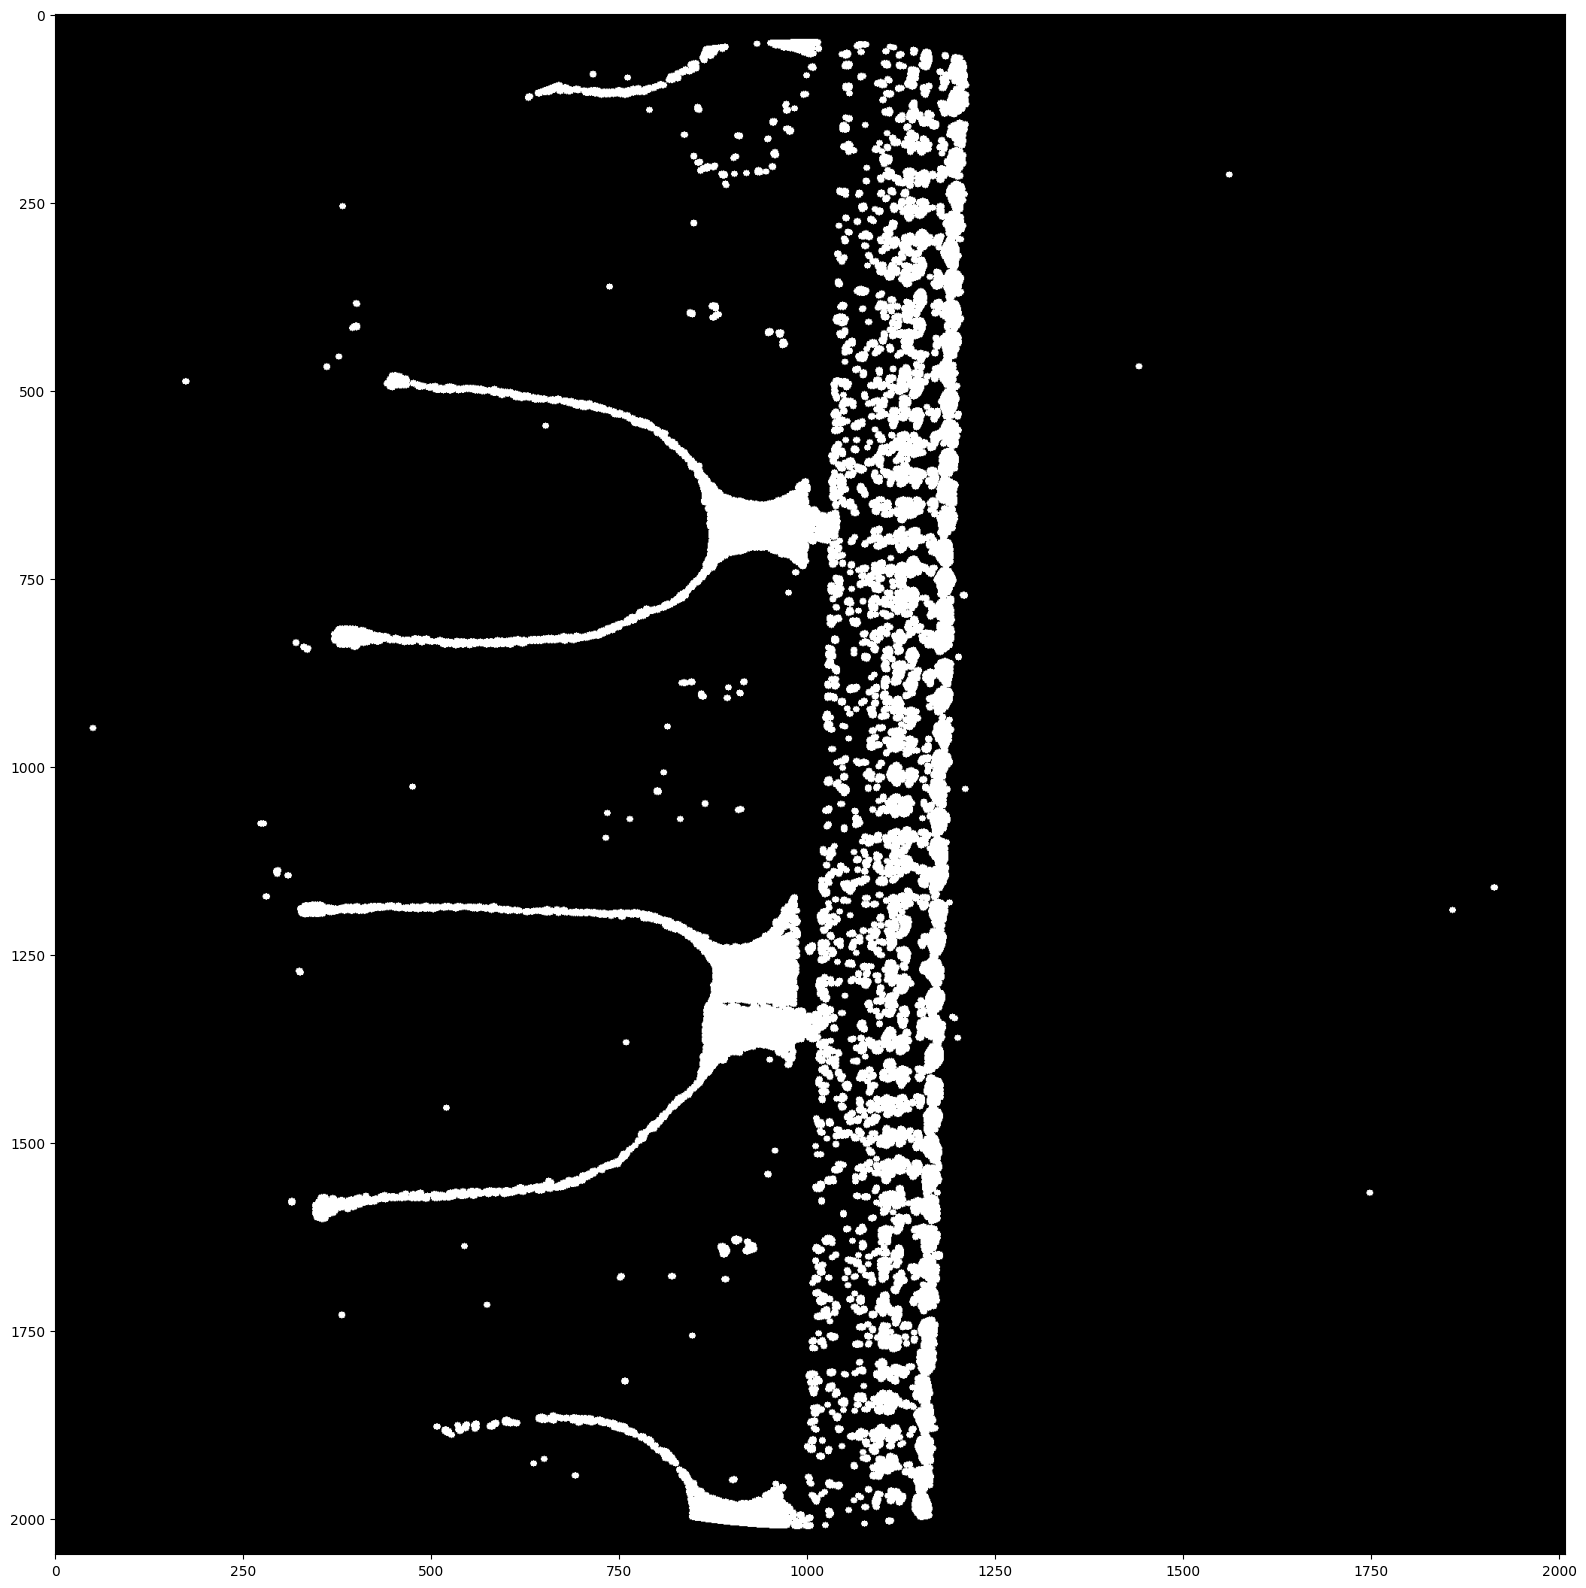

In [298]:
opening_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(35,35))
closing_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))

img = cv2.morphologyEx(img2  - avg_img, cv2.MORPH_OPEN, kernel)
# Gets plastic
ret, plastic = cv2.threshold(cv2.dilate(img1, opening_kernel), 61, 255, 0)

fig = plt.figure(figsize = (20, 20))
fig1 = fig.add_subplot(111)

# img = cv2.bitwise_and(img, img, mask=255 - plastic)
img = cv2.bitwise_and(img, img, mask=np.array(img < 225, dtype='uint8') * 255)
# for i in range(1):
#     img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, closing_kernel)

ret, thresh = cv2.threshold(img, 1, 255, 0)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)))
fig1.imshow(thresh, cmap='gray', vmin=0, vmax=255)

In [243]:
np.mean(img)

4.186725753237051

In [259]:
np.array(img > 1, dtype='uint8')

array([0, 1], dtype=uint8)